In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Đọc dữ liệu
df = pd.read_csv(r"/content/BTC.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Chuyển đổi ngày và sắp xếp
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [ ]:
# Chỉ lấy giá đóng cửa
close_prices = df['Close'].values.reshape(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

In [ ]:

#  Tạo chuỗi thời gian
window_size = 30
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])
X, y = np.array(X), np.array(y)

In [ ]:
# Tách tập train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# Hàm mất mát Gaussian NLL
def gaussian_nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_var = y_pred[:, 1]
    var = tf.exp(log_var)
    return tf.reduce_mean(0.5 * (log_var + tf.square(y_true[:, 0] - mean) / var))

In [ ]:
#Xây dựng mô hình Transformer đơn giản
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Dense(64)(inputs)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(2)(x)  # mean và log-variance

    model = models.Model(inputs, outputs)
    return model


In [ ]:
#  Biên dịch và huấn luyện
model = build_model((30, 1))
model.compile(optimizer="adam", loss=gaussian_nll)

# reshape lại y để khớp với loss
y_train_full = np.concatenate([y_train, np.zeros_like(y_train)], axis=1)
y_test_full = np.concatenate([y_test, np.zeros_like(y_test)], axis=1)

model.fit(X_train, y_train_full, epochs=10, batch_size=32, validation_data=(X_test, y_test_full))

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: -0.2350 - val_loss: -1.6057
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -1.1013 - val_loss: -1.9480
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -1.4045 - val_loss: -2.1354
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -1.8002 - val_loss: -2.2074
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -2.1468 - val_loss: -2.4322
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -2.5056 - val_loss: -2.2792
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -2.7782 - val_loss: -2.3709
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: -2.4652 - val_loss: -2.2497
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -2.5880 - val_loss: -2.7117
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -2.4552 - val_loss: -2.6103


In [ ]:
y_pred = model.predict(X_test)
mu = y_pred[:, 0]
log_var = y_pred[:, 1]
std = np.exp(0.5 * log_var)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [ ]:
mae = mean_absolute_error(y_test, mu)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
rmse = np.sqrt(mean_squared_error(y_test, mu))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.0333
Root Mean Squared Error (RMSE): 0.0455


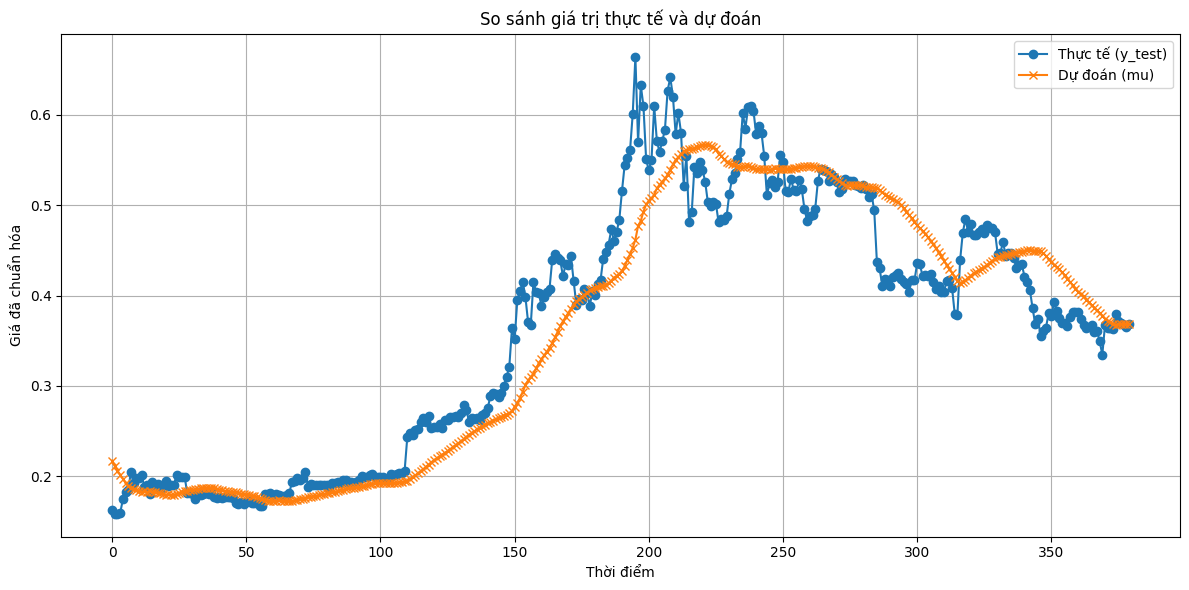

In [ ]:
import matplotlib.pyplot as plt # Import the plotting library
import numpy as np # Ensure numpy is imported for array handling

plt.figure(figsize=(12, 6))
# Use the defined variables y_test and mu for plotting
plt.plot(y_test, label='Thực tế (y_test)', marker='o')
plt.plot(mu, label='Dự đoán (mu)', marker='x')
plt.title("So sánh giá trị thực tế và dự đoán")
plt.xlabel("Thời điểm")
plt.ylabel("Giá đã chuẩn hóa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()